<a href="https://colab.research.google.com/github/kayleefoor/Foor_DSPN_S24/blob/main/Exercise9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 9: Classification

This homework assignment is designed to give you practice with classification models. We'll try to predict which words are more likely to be responded to correctly during a lexical decision task, based on their length and frequency.

We will be using data from the English Lexicon Project again. However, this time we will use response correctness as our dependent variable. Load **LexicalData_withIncorrect.csv**, which includes incorrect trials as well as correct ones, and also **Items.csv**. Both can be found in the *Homework/lexDat* folder in the class GitHub repository.

This data is a subset of the [English Lexicon Project database](https://elexicon.wustl.edu/). It provides response correctness and reaction times (in milliseconds) of many subjects as they are presented with letter strings and asked to decide, as quickly and as accurately as possible, whether the letter string is a word or not. The **Items.csv** provides characteristics of the words used, namely frequency (how common is this word?) and length (how many letters?).

*Data courtesy of Balota, D.A., Yap, M.J., Cortese, M.J., Hutchison, K.A., Kessler, B., Loftis, B., Neely, J.H., Nelson, D.L., Simpson, G.B., & Treiman, R. (2007). The English Lexicon Project. Behavior Research Methods, 39, 445-459.*

1. Loading and formatting the data 1/1
2. Visualizing the data 1/1
3. Logisic Regression: Fitting the model 2/2
4. Interpreting predictions from the model
5. QDA

---
## 1. Loading and formatting the data (1 point)

Load in data from the **LexicalData_withIncorrect.csv** and **Items.csv** files. Use `left_join` to add word characteristics `Length` and `Log_Freq_Hal` from **Items** to the **LexicalData**, and use `drop_na()` to get rid of any observations with missing values. Then use `head()` to look at the first few rows of the data.

*Note: We're just working with `Correct` in this homework, so no need to worry about reformatting reaction times.*

In [ ]:
library(readr)
library(dplyr)
library(tidyr)
lexdat <- read_csv("https://raw.githubusercontent.com/CoAxLab/DataSciencePsychNeuro/53424ae411f58eeda82b2663e123e7d91b27606d/Homework%20datasets/lexDat/LexicalData_withIncorrect.csv")
items <- read_csv("https://raw.githubusercontent.com/CoAxLab/DataSciencePsychNeuro/53424ae411f58eeda82b2663e123e7d91b27606d/Homework%20datasets/lexDat/Items.csv")
head(lexdat)
head(items)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


New names:
• `` -> `...1`
Rows: 74869 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): D_Word
dbl (6): ...1, Sub_ID, Trial, Type, D_Zscore, Correct
num (1): D_RT
lgl (1): Outlier

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 30959 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Word
dbl (3): Occurrences, Length, Log_Freq_HAL
num (1): Freq_HAL

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,Sub_ID,Trial,Type,D_RT,D_Word,Outlier,D_Zscore,Correct
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<dbl>,<dbl>
1,157,1,1,710,browse,FALSE,-0.437,1
2,67,1,1,1094,refrigerant,FALSE,0.825,1
3,120,1,1,587,gaining,FALSE,-0.645,1
4,21,1,1,984,cheerless,FALSE,0.025,1
5,236,1,1,577,pattered,FALSE,-0.763,1
6,236,2,1,715,conjures,FALSE,-0.364,1


Occurrences,Word,Length,Freq_HAL,Log_Freq_HAL
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,synergistic,11,284,5.649
1,synonymous,10,951,6.858
1,syntactical,11,114,4.736
1,synthesis,9,6742,8.816
1,synthesized,11,2709,7.904
1,synthesizer,11,1390,7.237


In [ ]:
fdata <- left_join(lexdat, items[,c("Length","Log_Freq_HAL", "Word")], by = c("D_Word" = "Word"))
fdata <- drop_na(fdata)
head(fdata)

...1,Sub_ID,Trial,Type,D_RT,D_Word,Outlier,D_Zscore,Correct,Length,Log_Freq_HAL
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
1,157,1,1,710,browse,FALSE,-0.437,1,6,8.856
2,67,1,1,1094,refrigerant,FALSE,0.825,1,11,4.644
3,120,1,1,587,gaining,FALSE,-0.645,1,7,8.304
4,21,1,1,984,cheerless,FALSE,0.025,1,9,2.639
5,236,1,1,577,pattered,FALSE,-0.763,1,8,1.386
6,236,2,1,715,conjures,FALSE,-0.364,1,8,5.268


---
## 2. Visualizing the data (1 point)

First, we'll try to visualize whether trials that are responded to correctly versus incorrectly differ from each other in terms of word length and log frequency. The code is included below, so that this homework doesn't get too cumbersome. All you have to do is **change the name of the data set**, **run the code**, and **write some observations about the output**.

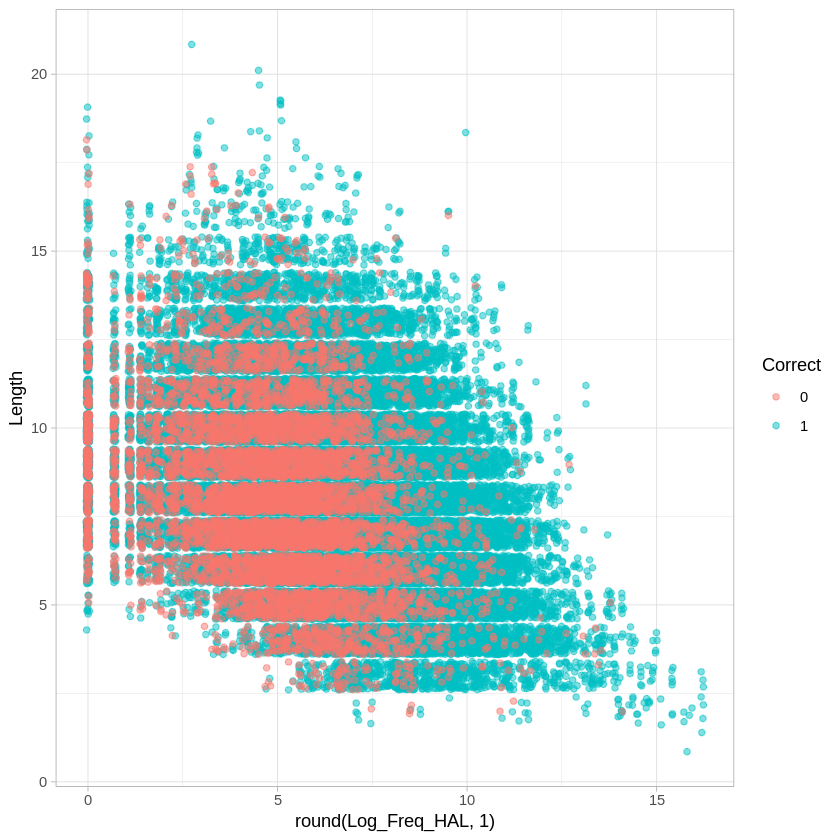

In [ ]:
library(tidyverse) # Load the tidyverse package, if you haven't yet
fdata$Correct <- as.factor(fdata$Correct) # so that R knows that Correct is categorical, not numeric.

# plot the Correct / Incorrect clusters
ggplot(fdata,aes(x=round(Log_Freq_HAL,1),y=Length,col=Correct)) + geom_point(position="jitter",alpha=0.5) + theme_light()


What do you observe about the "Correct" and "Incorrect" clusters?

> *The incorrect values seem to cluster around the lower values of Log_Freq_HAL, whereas the correct values are more widely spread. This indicates that when words show up less frequently, they are more likely to be answered incorrectly.*
>

---
## 3. Logistic Regression: Fitting the model (2 points)

Fit a logistic regression model to the data using `Length`, `Log_Freq_HAL`, and their interaction to predict `Correct`. Use `glm()` to fit the model, and look at its output using `summary()`.

In [ ]:
library(ggplot2)

In [ ]:
glm.fit <- glm(Correct~Length+Log_Freq_HAL+Length*Log_Freq_HAL, data=fdata, family=binomial)
summary(glm.fit)


Call:
glm(formula = Correct ~ Length + Log_Freq_HAL + Length * Log_Freq_HAL, 
    family = binomial, data = fdata)

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.939996   0.115623  -8.130 4.30e-16 ***
Length               0.151266   0.012789  11.828  < 2e-16 ***
Log_Freq_HAL         0.394772   0.018762  21.041  < 2e-16 ***
Length:Log_Freq_HAL -0.010558   0.002202  -4.795 1.63e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 49809  on 70588  degrees of freedom
Residual deviance: 46563  on 70585  degrees of freedom
AIC: 46571

Number of Fisher Scoring iterations: 5


What can you conclude from this output? (a brief gist is fine)

> *Based on this model, it appears that the interaction between the length and the log frequency of the word significantly predicts the likelihood that a participant gets the question correct.*
>

---
## 4. Interpreting predictions from the model (3 points)

Finally, look at how well this logistic regression model does at predicting correctness. Use `predict()` and a threshold of 0.5 to generate predicted `Correct` values for each trial, then output a confusion matrix and overall accuracy for these predictions.

*Hint: see the Classifiers tutorial.*

In [ ]:
glm_prob_df = data.frame(predict(glm.fit, type = "response"))
colnames(glm_prob_df) = c('predicted_prob')
num_observations = nrow(glm_prob_df)
contrasts(fdata$Correct)
threshold = 0.50
glm_prob_df$predicted_binary=rep("0",num_observations)
glm_prob_df$predicted_binary[glm_prob_df$predicted_prob>threshold]="1"
confusion_df = data.frame(glm_prob_df$predicted_binary, fdata$Correct)
colnames(confusion_df) = c('predicted', 'actual')
table(confusion_df)
print(paste("Accuracy:",mean(confusion_df$predicted == confusion_df$actual)))


[1] "Accuracy: 0.886526229299183"


Did the model do well at predicting lexical decision correctness? Why or why not?

> *To evaluate the model's prediction of lexical decision correctness, we take (13+62566)/70588 which equals 0.89. This means that the model is correct ~89% of the time in estimating whether the participant will answer correctly for a given word. This is a good value.*  
>

## 5. QDA (3 points)

Load in the `MASS` library and fit a QDA model to the data set. The predictors are still `Length`, `Log_Freq_HAL`, and their interaction, just like the logistic regression model you just ran, and the dependent variable is still `Correct`.

*Hint: see the Classifiers tutorial.*

In [ ]:
install.packages("MASS")
library(MASS)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




In [ ]:
qda.fit <- qda(Correct ~ Length + Log_Freq_HAL + Length*Log_Freq_HAL, data = fdata)
qda.fit

Call:
qda(Correct ~ Length + Log_Freq_HAL + Length * Log_Freq_HAL, 
    data = fdata)

Prior probabilities of groups:
        0         1 
0.1130346 0.8869654 

Group means:
    Length Log_Freq_HAL Length:Log_Freq_HAL
0 8.047124     4.932123            37.95260
1 7.979971     6.444849            49.34219

Now look at how well the predicted `Correct` values compare with actual `Correct` values for the whole data set. Output a confusion matrix and overall prediction accuracy.

In [ ]:
qda.pred = predict(qda.fit, fdata)
qda.class = qda.pred$class
table(qda.class, fdata$Correct)
print(paste("Accuracy:",mean(qda.class==fdata$Correct)))

         
qda.class     0     1
        0   455  1647
        1  7524 60963

[1] "Accuracy: 0.870078907478502"


How does QDA prediction performance differ from that of logistic regression?

> *The accuracy is slightly lower at 87%. Overall, this is still a good accuracy value.e*
>

**DUE:** 5pm EST, March 11, 2024

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here.
> *Someone's Name*